# Exploring
TODO: Add txt

In [10]:
import os
import sys
from functools import reduce
import matplotlib.pyplot as plt
import pandas as pd

# Import module up a directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import rooflineModel as rfm

def select(df, parts, sort=None):
    ap = map(lambda x: df[x[0]] == x[1], parts)
    id = reduce(lambda x,y: x & y, ap)
    ret = df[id]
    if sort is not None:
            ret = ret.sort_values(by=sort)
    return ret

def helper(which=None, batch_frequency=None, train_frequency=None, batch_size=None, ranks=None, episode_block=None):
    ret = []
    if which is not None:
        ret.append(("which", which))
    if batch_frequency is not None:
        ret.append(("batch_frequency", batch_frequency))
    if train_frequency is not None:
        ret.append(("train_frequency", train_frequency))
    if batch_size is not None:
        ret.append(("batch_size", batch_size))
    if ranks is not None:
        ret.append(("ranks", ranks))
    if episode_block is not None:
        ret.append(("episode_block", episode_block))
    return ret

### Change results to the directory with benchmark output.

In [3]:
force = False
csvDir = "./csvs"
results = "../convergenceTest/cartpole_batch_all/"
# train = rfm.getTraceDataframe(results, "train", csvDir=csvDir, prefix="train", force=force)
train = rfm.getTraceDataframe(results, "innertrain", csvDir=csvDir, prefix="train", force=force)
remember = rfm.getTraceDataframe(results, "innerremember", prefix="remember", csvDir=csvDir, force=force)
step = rfm.getTraceDataframe(results, "step", csvDir=csvDir, prefix="step", force=force)
data = rfm.getCartDataframe(results, csvDir=csvDir, force=force)

for df in [train, remember, step, data]:
    df['batch_frequency'] = df['batch_frequency'].mask(df['batch_frequency'] == -1, 100)

which = data["which"].unique()
batchFrequency = data["batch_frequency"].unique()
trainFrequency = data["train_frequency"].unique()
batchSize = data["batch_size"].unique()
ranks = data["ranks"].unique()
episodeBlock = data["episode_block"].unique()

batchFrequency.sort()
trainFrequency.sort()
batchSize.sort()
ranks.sort()

print("which", which)
print("batch frequency", batchFrequency)
print("train frequency", trainFrequency)
print("batch size", batchSize)
print("ranks", ranks)
print("episode block", episodeBlock, episodeBlock.dtype)

print(train.describe())
print(remember.describe())
print(step.describe())
print(data.describe())

Writing ./csvs/train____convergenceTest_cartpole_batch_all_.csv
Writing ./csvs/remember____convergenceTest_cartpole_batch_all_.csv
Writing ./csvs/step____convergenceTest_cartpole_batch_all_.csv
Writing ./csvs/___convergenceTest_cartpole_batch_all_.csv
which ['async']
batch frequency [  1   2   5  10  50 100]
train frequency [  1   2   5  10 100]
batch size [ 32  73 128 256 512]
ranks [ 2  5  9 17 24]
episode block [False  True] bool
       batch_frequency         ranks  train_frequency    batch_size  \
count     7.287783e+06  7.287783e+06     7.287783e+06  7.287783e+06   
mean      1.146861e+01  1.288184e+01     2.382097e+01  1.958949e+02   
std       2.488338e+01  8.281572e+00     3.850202e+01  1.720444e+02   
min       1.000000e+00  2.000000e+00     1.000000e+00  3.200000e+01   
25%       1.000000e+00  5.000000e+00     2.000000e+00  7.300000e+01   
50%       2.000000e+00  9.000000e+00     5.000000e+00  1.280000e+02   
75%       5.000000e+00  2.400000e+01     1.000000e+01  2.560000e+0

/people/suet688/.conda/envs/bsuiteClone/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  if __name__ == '__main__':


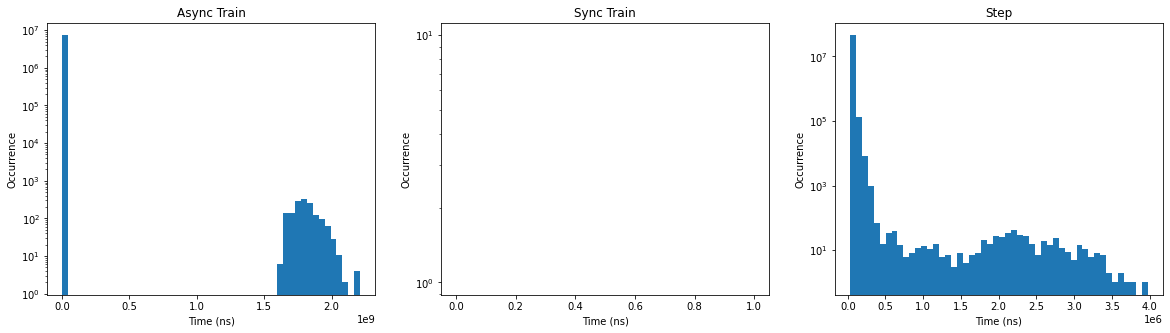

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
dfs = [train, remember, step]
cols = ["time", "time", "time"]
labels = ["Async Train", "Sync Train", "Step"]
for i, (df, col, label) in enumerate(zip(dfs, cols, labels)): 
    axes[i].hist(df[col], align="mid", label=label, bins=50)
    axes[i].set_xlabel("Time (ns)")
    axes[i].set_ylabel("Occurrence")
    axes[i].set_yscale("log")
    axes[i].set_title(label)
    # axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

(1228949.1796898711, 1634529.4519325013, 1582.3104796320613)
(46566.32538857078, 47456.43668225715, 23.169491349218145)
   which  episode_block  batch_frequency  train_frequency  batch_size  \
0  async          False                1                1          32   
1  async          False                1                1          32   
2  async          False                1                1          32   
3  async          False                1                1          32   
4  async          False                1                1          32   

   quartMean         ranks          mean   stdPercent  
0          2  1.137831e+06  1.393544e+06  1435.391371  
1          5  1.182158e+06  1.430910e+06  1382.516203  
2          9  1.128394e+06  1.388004e+06  1538.765452  
3         17  1.186417e+06  1.327131e+06  1226.168134  
4         24  1.370560e+06  1.410487e+06   545.746955  


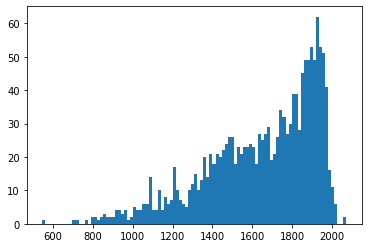

In [11]:
def getSpread(df):
    desc = df.describe()
    mean = desc["time"]["mean"]
    stdPercent = (desc["time"]["std"] / mean) * 100
    lower = desc.loc["25%", "time"]
    upper = desc.loc["75%", "time"]
    temp = df[(df["time"] >= lower) & (df["time"] <= upper)]["time"]
    return temp.mean(), mean, stdPercent

print(getSpread(train))
print(getSpread(step))

allStats = []
for df in [train, step]:
    stats = []
    for ep in episodeBlock:
        for b in batchFrequency:
            for tf in trainFrequency:
                for bs in batchSize:
                    for r in ranks:
                        temp = select(df, helper(which="async", episode_block=ep, batch_frequency=b, train_frequency=tf, batch_size=bs, ranks=r))
                        if len(temp):
                            stats.append(("async", ep, b, tf, bs, r, *getSpread(temp)))
                            # sns.displot(data=temp, x="time", hue="rank", kind="ecdf")
                            # plt.show()
    stats = pd.DataFrame(stats, columns=("which", "episode_block", "batch_frequency", "train_frequency", "batch_size", "quartMean", "ranks", "mean", "stdPercent"))
    print(stats.head())
    plt.hist(stats["stdPercent"], align="mid", bins=100)
    plt.show()
    allStats.append(stats)


In [6]:
def getAveFromQuartile(df):
    desc = df.describe()
    lower = desc.loc["25%", "time"]
    upper = desc.loc["75%", "time"]
    temp = df[(df["time"] >= lower) & (df["time"] <= upper)]["time"]
    return temp.mean()

aves = [getAveFromQuartile(x) for x in [train, step]]

In [6]:
ret = []
for w in which:
    for ep in [True, False]:
        for b in batchFrequency:
            for r in ranks:
                if w == "sync":
                    tempTrain = remember[(remember["which"] == w) & (remember["episode_block"] == ep) & (remember["batch_frequency"] == b) & (remember["ranks"] == r)]
                else:
                    tempTrain = train[(train["which"] == w) & (train["episode_block"] == ep) & (train["batch_frequency"] == b) & (train["ranks"] == r)]
                tempStep = step[(step["which"] == w) & (step["episode_block"] == ep) & (step["batch_frequency"] == b) & (step["ranks"] == r)]
                tempData = data[(data["which"] == w) & (data["episode_block"] == ep) & (data["batch_frequency"] == b) & (data["ranks"] == r)]
                if len(tempTrain) > 0 and len(tempStep):
                    assert len(tempData) == 1, len(tempData)
                    ret.append((w, ep, b, r, len(tempTrain), len(tempStep), float(tempData["time"])*1E9))
                    print(w, r, b, len(tempStep), tempStep["count"].max(), len(tempTrain), tempTrain["count"].max())
counts = pd.DataFrame(ret, columns=("which", "episode_block", "batch_frequency", "ranks", "train", "step", "time"))
# print(len(counts))
# print(counts)


async 2 1 7667 7667 7667 7667
async 5 1 13216 3304 13216 13216
async 9 1 7992 999 7992 7992
async 17 1 14704 919 14704 14704
async 24 1 13846 602 13846 13846
async 2 2 10565 10565 5351 5351
async 5 2 9472 2370 4800 4800
async 9 2 11003 1377 5568 5568
async 17 2 9967 626 5040 5040
async 24 2 19532 852 9867 9867
async 2 5 11584 11584 2461 2461
async 5 5 12386 3102 2620 2620
async 9 5 11464 1444 2416 2416
async 17 5 13895 878 2944 2944
async 24 5 24753 1087 5198 5198
async 2 10 23845 23845 2699 2699
async 5 10 24915 6244 2820 2820
async 9 10 23401 2984 2616 2616
async 17 10 23121 1469 2608 2608
async 24 10 27046 1203 3013 3013
async 2 50 38520 38520 1533 1533
async 5 50 63154 15856 2232 2232
async 9 50 37169 4728 1440 1440
async 17 50 36121 2311 1504 1504
async 24 50 33047 1494 1334 1334
async 2 100 96251 96251 2321 2321
async 5 100 34520 8721 1360 1360
async 9 100 63222 8109 1688 1688
async 17 100 50261 3230 1552 1552
async 24 100 78265 3520 1909 1909
async 2 1 6939 6939 6939 6939
async 

In [11]:
alphaSync = [("Sync Train", 0, 1 / aves[1])]
alphaAsync = [("Async Train", 0, 1 / aves[0])]
betas = [(str(r) + " Rank Step", (r * 1/aves[2]), 0) for r in ranks]

print(alphaSync)
print(alphaAsync)
print(betas)

[('Sync Train', 0, 7.565882145111442e-07)]
[('Async Train', 0, 7.436138386163937e-07)]
[('1 Rank Step', 2.1556982838254543e-05, 0), ('2 Rank Step', 4.3113965676509086e-05, 0), ('5 Rank Step', 0.00010778491419127273, 0), ('9 Rank Step', 0.00019401284554429091, 0), ('17 Rank Step', 0.00036646870825032726, 0), ('24 Rank Step', 0.000517367588118109, 0)]


In [13]:
temp = counts[(counts["which"] == "sync")]
dataToPlot = {"Sync": (list(temp["step"] / temp["train"]), list(temp["train"] / temp["time"]) )}

0.001 100.0 1e-09 0.001


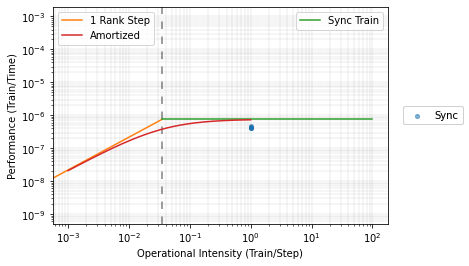

In [14]:
rf = rfm.Roofline(alphaSync, betas[:1], "Operational Intensity (Train/Step)", "Performance (Train/Time)", xlim=(1E-3, 1E2), ylim=(1E-9, 1E-3))
rf.addAmortized("Amortized", "Sync Train", "1 Rank Step")
rf.addData(dataToPlot)
rf.plot()

1e-06 100.0 1e-09 0.001


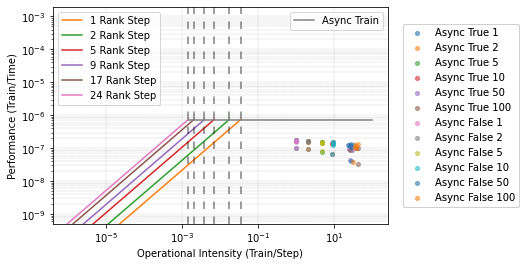

In [16]:
dataToPlot = {}
for ep in [True, False]:
    for b in batchFrequency:
        temp = counts[(counts["which"] == "async") & (counts["episode_block"] == ep) & (counts["batch_frequency"] == b)] # & (data["ranks"] == r)
        if len(temp) > 0:
            dataToPlot["Async " + str(ep) + " " + str(b)] = (list(temp["step"] / temp["train"]), list(temp["train"] / temp["time"]) )

rf = rfm.Roofline(alphaAsync, betas, "Operational Intensity (Train/Step)", "Performance (Train/Time)", xlim=(1E-6, 1E2), ylim=(1E-9, 1E-3))
rf.addData(dataToPlot)
rf.plot()

1e-06 100.0 1e-09 0.001


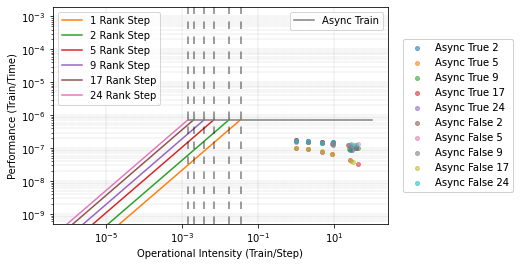

In [19]:
dataToPlot = {}
for ep in [True, False]:
    for r in ranks:
        temp = counts[(counts["which"] == "async") & (counts["episode_block"] == ep) & (data["ranks"] == r)]
        if len(temp):
            dataToPlot["Async " + str(ep) + " " + str(r)] = (list(temp["step"] / temp["train"]), list(temp["train"] / temp["time"]) )

rf = rfm.Roofline(alphaAsync, betas, "Operational Intensity (Train/Step)", "Performance (Train/Time)", xlim=(1E-6, 1E2), ylim=(1E-9, 1E-3))
rf.addData(dataToPlot)
rf.plot()

{'Async True 2': {'1': (4.727480916030534, 1.4524496524963388e-07), '2': (8.835106382978724, 1.2984980311754037e-07), '5': (25.38235294117647, 8.837842692304981e-08), '10': (1.9733333333333334, 1.5965031223888767e-07), '50': (28.294802867383513, 9.054232060465106e-08), '100': (1.0, 1.7070302817936448e-07)}}
1e-06 100.0 1e-09 0.001


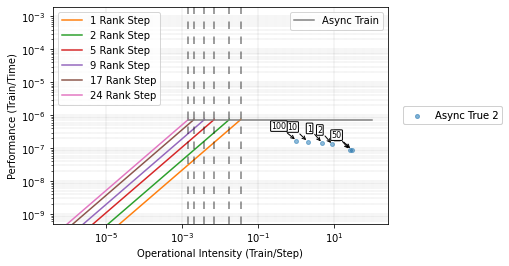

In [21]:
dataToPlot = {}
for ep in [True]:
    for r in [2]:
        tempDict = {}
        for b in batchFrequency:
            temp = counts[(counts["which"] == "async") & (counts["episode_block"] == ep) & (data["ranks"] == r) & (data["batch_frequency"] == b)]
            tempDict[str(b)] = (float(temp["step"] / temp["train"]), float(temp["train"] / temp["time"]))
        dataToPlot["Async " + str(ep) + " " + str(r)] = tempDict

# dataToPlot = {"Test":{"OK":(1E-1, 1E-8)}}
print(dataToPlot)
rf = rfm.Roofline(alphaAsync, betas, "Operational Intensity (Train/Step)", "Performance (Train/Time)", xlim=(1E-6, 1E2), ylim=(1E-9, 1E-3))
rf.addLabelData(dataToPlot)
rf.plot()

{'Async True 24': {'1': (4.745033112582782, 1.5357368543817246e-07), '2': (8.945336391437309, 1.510729988447334e-07), '5': (37.453791469194314, 1.0276397725468449e-07), '10': (1.9761135057471264, 1.6915853082113497e-07), '50': (25.811805555555555, 1.204900406260537e-07), '100': (1.0, 1.7337657424988948e-07)}}
0.001 100.0 1e-09 0.001


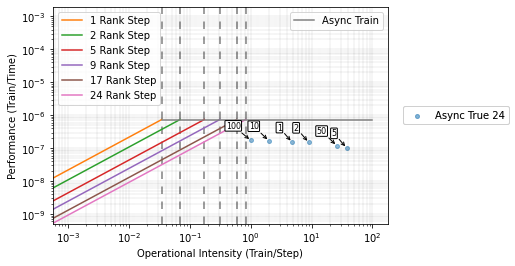

In [56]:
dataToPlot = {}
for ep in [True]:
    for r in [24]:
        tempDict = {}
        for b in batchFrequency:
            temp = counts[(counts["which"] == "async") & (counts["episode_block"] == ep) & (data["ranks"] == r) & (data["batch_frequency"] == b)]
            tempDict[str(b)] = (float(temp["step"] / temp["train"]), float(temp["train"] / temp["time"]))
        dataToPlot["Async " + str(ep) + " " + str(r)] = tempDict

# dataToPlot = {"Test":{"OK":(1E-1, 1E-8)}}
print(dataToPlot)
rf = rfm.Roofline(alphaAsync, betas, "Operational Intensity (Train/Step)", "Performance (Train/Time)", xlim=(1E-3, 1E2), ylim=(1E-9, 1E-3))
rf.addLabelData(dataToPlot)
rf.plot()

{'Async False 2': {'1': (4.7422284317149845, 1.5596162974948134e-07), '2': (8.936410256410257, 1.518830702053767e-07), '5': (36.052763819095475, 1.0395996739147983e-07), '10': (1.9750716964482682, 1.612067253819335e-07), '50': (23.39240506329114, 1.22665041849106e-07), '100': (1.0, 1.8339278331631004e-07)}, 'Async False 24': {'1': (4.7372093023255815, 1.417778301031843e-07), '2': (8.95742092457421, 1.5069131968974804e-07), '5': (37.9563350035791, 1.2324876895161608e-07), '10': (1.9753986332574032, 1.6389309784037202e-07), '50': (26.840842598010532, 1.34940494873174e-07), '100': (1.0, 1.6792232805112636e-07)}}
0.001 100.0 1e-09 0.001


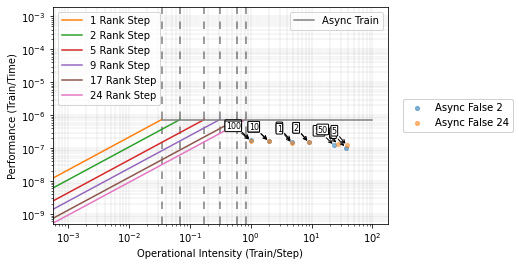

In [57]:
dataToPlot = {}
for ep in [False]:
    for r in [2, 24]:
        tempDict = {}
        for b in batchFrequency:
            temp = counts[(counts["which"] == "async") & (counts["episode_block"] == ep) & (data["ranks"] == r) & (data["batch_frequency"] == b)]
            tempDict[str(b)] = (float(temp["step"] / temp["train"]), float(temp["train"] / temp["time"]))
        dataToPlot["Async " + str(ep) + " " + str(r)] = tempDict

# dataToPlot = {"Test":{"OK":(1E-1, 1E-8)}}
print(dataToPlot)
rf = rfm.Roofline(alphaAsync, betas, "Operational Intensity (Train/Step)", "Performance (Train/Time)", xlim=(1E-3, 1E2), ylim=(1E-9, 1E-3))
rf.addLabelData(dataToPlot)
rf.plot()

## Plotting the Roofline
Our next step is to plot the rooflines with the upper and lower bounds we found in the network abstraction notebook.  We will look at tile sizes of 1 (i.e. message sizes of 8 bytes) first.

In [6]:
baseGHz = 2.8
turboGHz = 3.7
cores = 1
baseFP = 16 * baseGHz * cores * 1E9
peakFP = 16 * turboGHz * cores * 1E9

print("Base FLOPS:", baseFP, "Peak FLOPS:", peakFP)
pi = [("Base FP", 0, baseFP), ("Peak FP", 0, peakFP)]

messageSizes = [8]
betas = [("Bandwidth " + str(size), bandwidths.loc[size, "Max Bandwidth"], 0) for size in messageSizes]
betas.extend([("Latency " + str(size), bandwidths.loc[size, "Max Latency"], 0) for size in messageSizes])

Base FLOPS: 44800000000.0 Peak FLOPS: 59200000000.0


In this roofline we will focus on the scale benchmark.  To provide a more reasonable upper bound, we use the performance of the original scale benchmark.  We will look at two refinements to pi.  The first is running the default stream benchmark.  This will have none of the MPI calls or additional loops/conditionals.  The second $\pi$ will be calling the (modified) stream code with the additional loops/conditionals on a single rank.  The MPI calls will not be called however since all tiles will be owned by a single rank.  The performance of modified stream changes as we change the size of the tile.  We will explore this later in the notebook, however for now we plot the lowest observed modified stream performance.  Notice that the throughput (performance rate) is lower than the original stream benchmark.  This is due to the instruction mix.

In [7]:
rate = simple["scaleOpts"]/(simple["scaleMin"])
pi.append(("Default Stream", 0, list(rate)[0]))

rate = serial["scaleOpts"]/(serial["scaleMax"])
pi.append(("Modified Stream", 0, rate.min()))


Lastly, we plot the roofline.  For the distribution method, we add an amortized analysis line.  The amortized analysis line is used when the network operations can't be overlapped with the floating-point execution.

1 100000.0 100000000.0 10000000000000.0


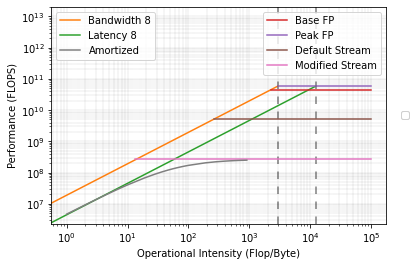

In [8]:
rf = rfm.Roofline(pi, betas, "Operational Intensity (Flop/Byte)", "Performance (FLOPS)", xlim=(1, 1E5), ylim=(1E8, 1E13))
rf.addAmortized("Amortized", "Modified Stream", "Latency 8")
rf.plot()

The following is a cleaned up version of the plot above with data from our stream run.  We are plotting the results of the stream benchmark for a tile size of 1.  We remove the additional $\pi$'s.  In this cleaned up code, we use $\pi$'s from the modified stream code across various tile sizes.  Notice the region between the $\pi$'s is somewhat smaller but still large.

1 100000.0 100000000.0 1e+16


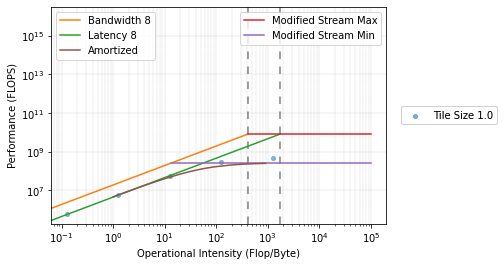

In [9]:
pi = []
# rate = simple["scaleOpts"]/(simple["scaleMin"])
# pi.append(("Default Stream Min", 0, list(rate)[0]))

# rate = simple["scaleOpts"]/(simple["scaleAve"])
# pi .append(("Default Stream Ave", 0, list(rate)[0]))

# rate = simple["scaleOpts"]/(simple["scaleMax"])
# pi.append(("Default Stream Max", 0, list(rate)[0]))

rate = serial["scaleOpts"]/(serial["scaleMin"])
# pi.append(("Modified Stream Min Min", 0, rate.min()))
pi.append(("Modified Stream Max", 0, rate.max()))

rate = serial["scaleOpts"]/(serial["scaleMax"])
pi.append(("Modified Stream Min", 0, rate.min()))
# pi.append(("Modified Stream Max Max", 0, rate.max()))

scale = data[data["tileSize"] == 1]
rate = scale["arraySize"]*scale["reps"]/(scale["scaleMin"])
dataToPlot = {"Tile Size " + str(tileSize):( list(scale["arraySize"] * scale["reps"] / (scale["arraySize"] * 8)), list(rate) )}

rf = rfm.Roofline(pi, betas, "Operational Intensity (Flop/Byte)", "Performance (FLOPS)", xlim=(1, 1E5), ylim=(1E8, 1E16))
rf.addAmortized("Amortized", "Modified Stream Min", "Latency 8")
rf.addData(dataToPlot)
rf.plot()

The range provide of $\pi$'s provided above cover the minimum and maximum performance observed across the tested tile sizes.  The plot below show the minimum and maximum performance for a single tile size corresponding to our data (tile size of 1).  Notice the bound box is more tight.

1 100000.0 100000000.0 1e+16


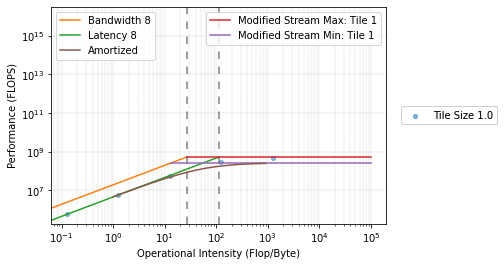

In [10]:
pi = []
rate = serial[serial["tileSize"] == 1]
rate = rate["scaleOpts"]/(rate["scaleMin"])
pi.append(("Modified Stream Max: Tile 1", 0, rate.max()))

rate = serial[serial["tileSize"] == 1]
rate = rate["scaleOpts"]/(rate["scaleMax"])
pi.append(("Modified Stream Min: Tile 1", 0, rate.min()))

scale = data[data["tileSize"] == 1]
rate = scale["arraySize"]*scale["reps"]/(scale["scaleMin"])
dataToPlot = {"Tile Size " + str(tileSize):( list(scale["arraySize"] * scale["reps"] / (scale["arraySize"] * 8)), list(rate) )}

rf = rfm.Roofline(pi, betas, "Operational Intensity (Flop/Byte)", "Performance (FLOPS)", xlim=(1, 1E5), ylim=(1E8, 1E16))
rf.addAmortized("Amortized", "Modified Stream Min: Tile 1", "Latency 8")
rf.addData(dataToPlot)
rf.plot()

## Exploring $\pi$
The performance of the modified stream benchmark has several interesting effects happening at the same time.  The following is an initial exploration.  The most probable cause in performance difference and we change the tile size and reps is the cache.

In the first plot, we see that the number of reps acts as a scaler on the total time.  We can see in the second graph, when we normalize by the number of operations to get the performance (i.e. a throughput rate), the effect of the number of reps mostly disappears with the exception of the single rep case.

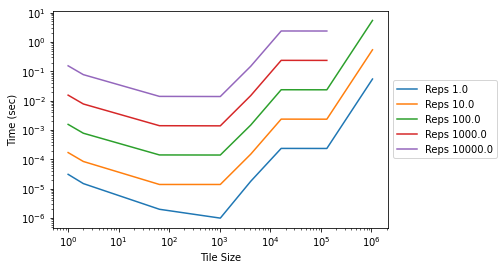

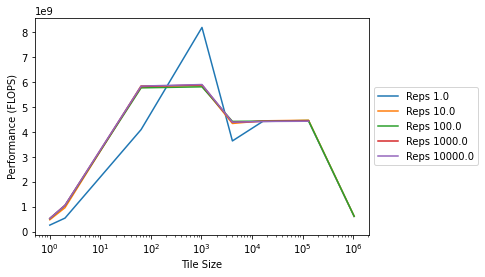

In [11]:

minMaxAve = "scaleAve"
reps = serial["reps"].unique().tolist()

# plt.scatter(1, simple[minMaxAve], label="Base")
for rep in reps:
        toPlot = serial[(serial["reps"] == rep)]
        toPlot = toPlot.sort_values(by=["tileSize"])
        plt.plot(toPlot["tileSize"], toPlot[minMaxAve], label="Reps " + str(rep))

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Tile Size")
plt.ylabel("Time (sec)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

for rep in reps:
        toPlot = serial[(serial["reps"] == rep)]
        toPlot = toPlot.sort_values(by=["tileSize"])
        plt.plot(toPlot["tileSize"], toPlot["arraySize"]*toPlot["reps"]/toPlot[minMaxAve], label="Reps " + str(rep))

plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Tile Size")
plt.ylabel("Performance (FLOPS)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


Next we try interchanging the tile and reps loop to guess if this is what the compiler is doing as this would have a significant cache effect.  When we look at the resulting graphs, we observe a very different performance profile suggesting this is not what the compiler is doing.

Ultimately it seems we have more work to do to understand how tight we can make the pi upper bound.

Reading ../data/junction/csvs/___data_junction_raw_stream_interchange.csv


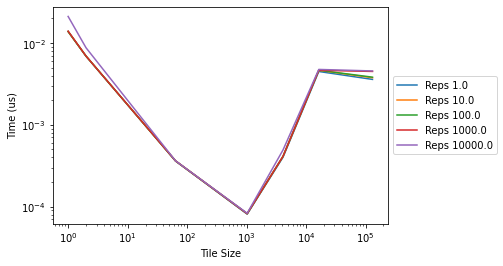

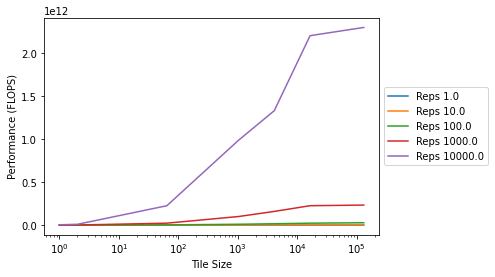

In [12]:
interchangeResults = "../data/junction/raw/stream_interchange"
loop = rfm.getStreamDataframe(interchangeResults, csvDir=csvDir)
loop = loop[loop["which"] == "send"]

reps = loop["reps"].unique().tolist()

# plt.scatter(1, simple[minMaxAve], label="Base")
for rep in reps:
        toPlot = loop[(loop["reps"] == rep)]
        toPlot = toPlot.sort_values(by=["tileSize"])
        plt.plot(toPlot["tileSize"], toPlot[minMaxAve], label="Reps " + str(rep))

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Tile Size")
plt.ylabel("Time (us)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

for rep in reps:
        toPlot = loop[(loop["reps"] == rep)]
        toPlot = toPlot.sort_values(by=["tileSize"])
        plt.plot(toPlot["tileSize"], toPlot["arraySize"]*toPlot["reps"]/toPlot[minMaxAve], label="Reps " + str(rep))

plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Tile Size")
plt.ylabel("Performance (FLOPS)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()